#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
#Импортируем библиотеки
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, TimeSeriesSplit, train_test_split

In [2]:
#Загружаем данные в переменную, переводим 1й столбец в формат datetime
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
#Познакомимся с данными
df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
#Сортируем индексы
df.sort_index(inplace=True)

In [5]:
#Делаем ресемплинг по часу
df = df.resample('1H').sum()

## Анализ

Посмотрим, что из себя представляет временной промежуток.

In [6]:
print(f'Временной промежуток данных: {df.index.min()} - {df.index.max()}')

Временной промежуток данных: 2018-03-01 00:00:00 - 2018-08-31 23:00:00


Декомпозируем временной ряд на три части: сезонность, тренд и остатки.

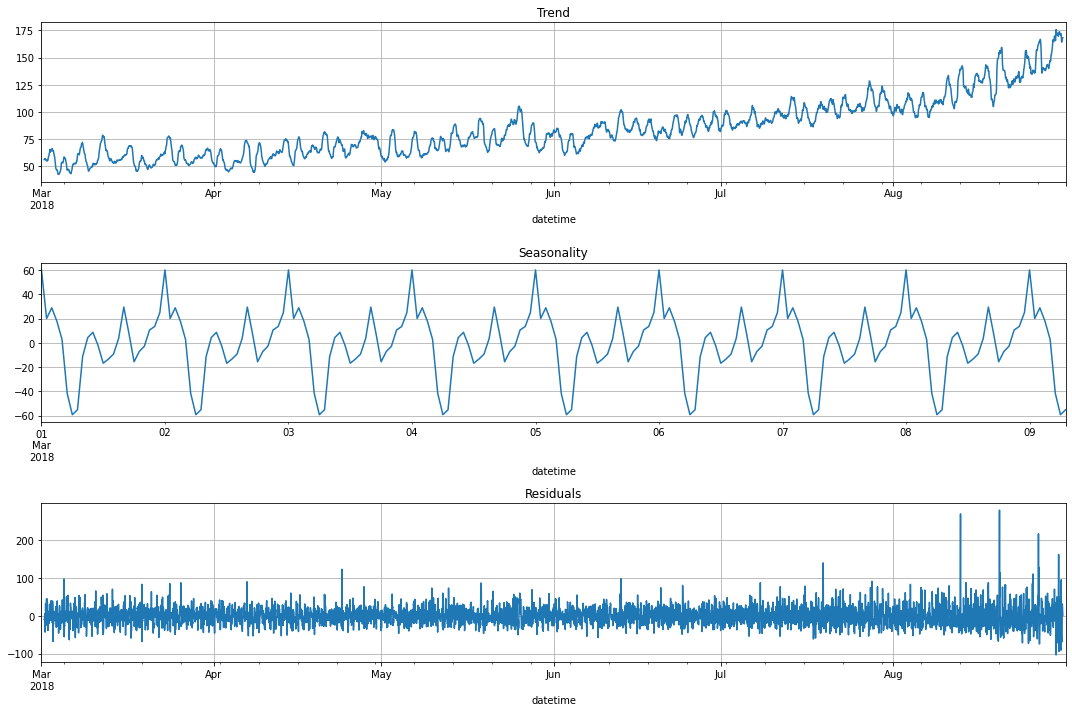

In [7]:
#Декомпозируем и строим графики
decomposed = seasonal_decompose(df)

plt.figure(figsize=(15, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.grid(True)

plt.subplot(312)
decomposed.seasonal.head(200).plot(ax=plt.gca())
plt.title('Seasonality')
plt.grid(True)

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.grid(True)
plt.tight_layout()

- Наблюдается растущий тренд на количество заказов такси
- Сезонность имеет ярковыраженный суточный цикл: утром заказов почти нет, т.к. люди спят, затем виден ожидаемый рост в связи с приближающимся началом рабочего дня, после чего люди возвращаются домой с работы и/или после вечера, проведенного вне дома, а дальше спад повторяется и начинается новый цикл
- В остатках все достаточно стабильно, но местами наблюдаются резкие всплески заказов. Возможно, это связано с вечером пятницы, когда все гуляют по кабакам и/или с плохой погодой, когда на своих двоих передвигаться слишком мокро.

Проверим, как ведет себя скользящее среднее, а заодно оценим, является ряд стационарным или нет. Учитывая, растущий во времени тренд на количество заказов, ряд выглядит нестационарным. Проверим

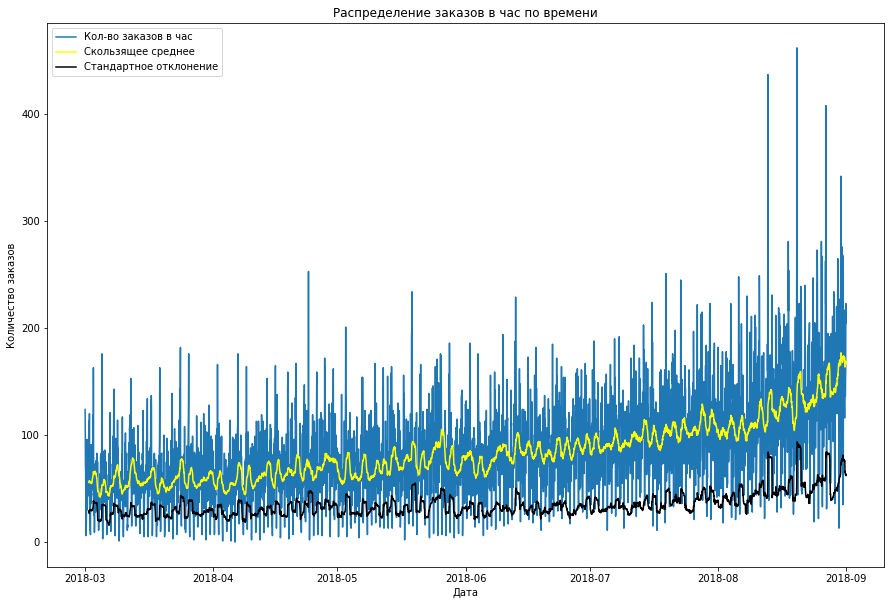

In [8]:
#Строим график
plt.figure(figsize=(15, 10))
plt.plot(df)
plt.plot(df.rolling(24).mean(), color='yellow')
plt.plot(df.rolling(24).std(), color='black')
plt.title('Распределение заказов в час по времени')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.legend(['Кол-во заказов в час', 'Скользящее среднее', 'Стандартное отклонение'])
plt.show()

Видно, что со временем ряд становится нестационарным. Попробуем проверить стационарность ряда тестом Дики-Фуллера.

In [9]:
#Пишем функцию
def test_stationarity(df):
    result = adfuller(df['num_orders'])

    print('Критические значения:', result[4])
    print('p-value:', result[1])
    
    # Оценка стационарности на основе p-значения
    if result[1] <= 0.05:
        print('Ряд является стационарным.')
    else:
        print('Ряд не является стационарным.')

In [10]:
#Проверяем
test_stationarity(df)

Критические значения: {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
p-value: 0.028940051402612906
Ряд является стационарным.


Согласно тесту, ряд является стационарным. Это расходится с наблюдениями на графике тренда. Что ж, примем к сведению, но останемся на своем.

In [11]:

# код ревьювера
from statsmodels.tsa.stattools import adfuller

ts = df['num_orders']
st_test = adfuller(ts, regression='ctt')

print('Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный')
if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')


Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный
Наш ряд стационарный


## Обучение

In [12]:
#Пишем функцию для создания признаков
def make_features(df, max_lag, rolling_mean_size):
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

In [13]:
#Проверяем
make_features(df, 168, 24)

df.head(7)

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,1,3,43.0,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,1,3,6.0,43.0,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
#Удаляем строки с пропусками
df.dropna(inplace=True)

In [15]:
#Создаем переменные feature и target
features = df.drop('num_orders', axis=1)
target = df['num_orders']

print(features.shape)
print(target.shape)

(4248, 171)
(4248,)


In [16]:
#Делим features и target на выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, shuffle=False, test_size=0.1
)

print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(3823, 171)
(3823,)
(425, 171)
(425,)


In [17]:
#Масштабируем признаки
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_test_scaled = scaler.transform(features_test)

In [18]:
#Строим модель линейной регрессии
tscv = TimeSeriesSplit(n_splits=3)

linear_params = {
    'fit_intercept': [True, False],
    'normalize': [True, False]
}

linear = LinearRegression()
linear_random_search = RandomizedSearchCV(
    linear,
    param_distributions=linear_params,
    n_iter=4,
    cv=tscv,
    random_state=12345)

linear_random_search.fit(features_train_scaled, target_train)
best_linear_model = linear_random_search.best_estimator_

rmse_linear = -cross_val_score(
    best_linear_model,
    features_train_scaled,
    target_train,
    scoring='neg_root_mean_squared_error',
    cv=tscv).mean()

print(f'RMSE лучшей модели линейной регрессии: {rmse_linear}')

RMSE лучшей модели линейной регрессии: 23.180334529604057


In [19]:
#Строим LightGBM модель
lgbmr_params = {
    'n_estimators': [26],
    'max_depth': [1, 3]
}

lgbmr = lgb.LGBMRegressor()
lgbmr_random_search = RandomizedSearchCV(
    lgbmr,
    param_distributions=lgbmr_params,
    n_iter=2,
    cv=tscv,
    random_state=12345)

lgbmr_random_search.fit(features_train_scaled, target_train)
best_lgbmr_model = lgbmr_random_search.best_estimator_

rmse_lgbmr = -cross_val_score(
    best_lgbmr_model,
    features_train_scaled,
    target_train,
    scoring='neg_root_mean_squared_error',
    cv=tscv).mean()

print(f'RMSE лучшей LightGBM модели: {rmse_lgbmr}')

RMSE лучшей LightGBM модели: 24.164617073071195


In [20]:
#Строим CatBoost модель
catboost_params = {
    'depth': [3],
    'learning_rate': [0.1, 1]
}

catboost = CatBoostRegressor(verbose=False)
catboost_random_search = RandomizedSearchCV(
    catboost,
    param_distributions=catboost_params,
    n_iter=2,
    cv=tscv,
    random_state=12345)

catboost_random_search.fit(features_train_scaled, target_train)
best_catboost_model = catboost_random_search.best_estimator_

rmse_catboost = -cross_val_score(
    best_catboost_model,
    features_train_scaled,
    target_train,
    scoring='neg_root_mean_squared_error',
    cv=tscv).mean()

print(f'RMSE лучшей CatBoost модели: {rmse_catboost}')

RMSE лучшей CatBoost модели: 24.20623221089852


In [21]:
#Пишем модель Lasso
lasso_params = {'alpha': [0.1, 1, 10]}

lasso = Lasso()
lasso_random_search = RandomizedSearchCV(
    lasso,
    param_distributions=lasso_params,
    n_iter=3,
    cv=tscv,
    random_state=12345)

lasso_random_search.fit(features_train_scaled, target_train)
best_lasso_model = lasso_random_search.best_estimator_

rmse_lasso = -cross_val_score(
    best_lasso_model,
    features_train_scaled,
    target_train,
    scoring='neg_root_mean_squared_error',
    cv=tscv).mean()

print(f'RMSE лучшей модели Lasso: {rmse_lasso}')

RMSE лучшей модели Lasso: 22.667754770898387


## Тестирование

In [22]:
#Собираем таблицу с отчетом
results = [
    {'RMSE': round(rmse_linear, 2)},    
    {'RMSE': round(rmse_lgbmr, 2)},
    {'RMSE': round(rmse_catboost, 2)},
    {'RMSE': round(rmse_lasso, 2)}
]

pd.DataFrame(data=results,
             index=['LinearRegression', 'LightGBM', 'CatBoost', 'Lasso'],
             columns=['RMSE']).sort_values(by='RMSE')

,RMSE
Lasso,22.67
LinearRegression,23.18
LightGBM,24.16
CatBoost,24.21


Лучший результат на кросс-валидации у линейных моделей, но модель Lasso незначительно опережает модель линейной регрессии. Используем Lasso для подсчета RMSE на тестовой выборке.

In [26]:
#Считаем RMSE модели Lasso на тестовой выборке
predictions_lasso = best_lasso_model.predict(features_test_scaled)
rmse_lasso = mse(target_test, predictions_lasso)**0.5
print(rmse_lasso)

34.764062266119836


Дополнительно проверим модель ни адекватность. Если RMSE Lasso будет больше или равно RMSE с предсказанием предыдущим значением, модель будем считать неадекватной. Если RMSE Lasso будет меньше - адекватной.

In [27]:
#Проверяем лучшую модель на адекватность
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]

rmse_previous = mse(target_test, pred_previous)**0.5

# Сравнение RMSE моделей
if rmse_lasso < rmse_previous:
    print("Модель Lasso адекватна")
else:
    print("Модель Lasso не адекватна")

Модель Lasso адекватна


**Вывод:**

Модель Lasso показала лучший результат RMSE в 34.76 на тестовой выборке, что меньше заявленного в условии проекта значения в 48, а значит, что мы справились. Также мы проверили и подтвердили адекватность модели.